### aim: 

### date: 

In [113]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [114]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [115]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [116]:
scendict = {
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'color2':'orange'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'color2':'orangered'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'color2':'mediumseagreen'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'color2':'green'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'color2':'dodgerblue'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'color2':'mediumblue'}
}

## helper functions

In [117]:
def make_yearfiles_ukesm(yrst, yren, tscen, sig = False):
    #print(f'SCENARIO {tscen}')
    dslist = []
    
    tdir = '/gpfs/data/greenocean/software/resources/MEDUSA/ukesm_allscen_moc_byyear/'
    
    for y in range(yrst,yren):
        if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
            tstr = scendict['1A']['hist_str']
        elif y<2015:
            tstr = scendict[tscen]['hist_str']

        else:
            tstr = scendict[tscen]['fut_str']
        try:
            if sig:
                td = glob.glob(f'{tdir}/nemo_{tstr}o_1y_{y}_mocsig.nc')
            else:
                td = glob.glob(f'{tdir}/nemo_{tstr}o_1y_{y}_moc.nc')
            dslist.append(td[0])
            if (len(td) != 1):
                print(f'SCENARIO {tscen}, {y}, something missing')

        except:
            pass

    return dslist

def get_max_overturning(overturning_xarray):

    q= overturning_xarray.where(overturning_xarray==overturning_xarray.max(), drop=True).squeeze()
    lat = q.nav_lat.values
    depth = (q.depthw.values)
    ot = (q.values)
    
    return lat, depth, ot

def get_overturning_ts(mfdataset, yrst, yren):

    times = pd.date_range(f"{yrst}/01/01",f"{yren+1}/01/01",freq='YS',closed='left')

    max_overturning = np.zeros(len(times))
    max_overturning_d = np.zeros(len(times))
    max_overturning_lat = np.zeros(len(times))
    # print(times)

    for y in range(yrst,yren):
        
        i = y-yrst
        if y%10 == 0:
            print(y)
        test = mfdataset.zomsfglo.isel(y=slice(80,141)).sel(time_counter=slice(f'{y}-01-01', f'{y+1}-01-01')).isel(x=0).mean(dim = ['time_counter'])
        lat, depth, ot = get_max_overturning(test)
        # print(y)
        # print(lat)
        # print(depth)
        # print(ot)
        max_overturning[i] = (ot)
        max_overturning_d[i] = (depth)
        max_overturning_lat[i] = (lat)
    
    return times, max_overturning, max_overturning_d, max_overturning_lat



def make_overturning_ts(yrst,yren,scen):

    dslist_1A = make_yearfiles_ukesm(yrst, yren, scen)
    mfdataset = xr.open_mfdataset(dslist_1A, concat_dim='time_counter')

    times, max_overturning, max_overturning_d, max_overturning_lat = get_overturning_ts(mfdataset, yrst, yren)
    
    savenam = f'./intermediateCalc/overturning_ts_scen{scen}_{yrst}-{yren}.nc'
    data_vars = {'max_overturning':(['times'], max_overturning,
    {'units': 'Sv',
    'long_name':'max overturning in depth coordinates'}),
                 'max_overturning_d':(['times'], max_overturning_d,
    {'units': 'm',
    'long_name':'depth of maximum overturning'}),
                 'max_overturning_lat':(['times'], max_overturning_lat,
    {'units': 'degN',
    'long_name':'lat of maximum overturning'}),
    }
    # define coordinates
    coords = {'times': (['times'], times)}
    # define global attributes
    attrs = {'made in':'overturning/yearly_overturning.ipynb',
    'desc': 'overturning timeseries'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)
    
def get_mean_moc(mocf):
    tdat = xr.open_mfdataset(mocf)
    mn = tdat.zomsfglo.sel(y=slice(60,141)).mean(dim = ['time_counter']).mean(dim = ['x'])

    return mn
    
def get_mean_mocsig(mocf):
    tdat = xr.open_mfdataset(mocf)
    mn = tdat.dmoc2000.isel(latV=slice(60,141)).mean(dim = ['time_counter'])

    return mn

In [118]:
s1A_1950_1960_mocf = make_yearfiles_ukesm(1950, 1960, '1A', sig = False)
s1A_1950_1960_mocsigf = make_yearfiles_ukesm(1950, 1960, '1A', sig = True)
s1B_1950_1960_mocf = make_yearfiles_ukesm(1950, 1960, '1B', sig = False)
s1B_1950_1960_mocsigf = make_yearfiles_ukesm(1950, 1960, '1B', sig = True)

s2A_1950_1960_mocf = make_yearfiles_ukesm(1950, 1960, '2A', sig = False)
s2A_1950_1960_mocsigf = make_yearfiles_ukesm(1950, 1960, '2A', sig = True)
s2B_1950_1960_mocf = make_yearfiles_ukesm(1950, 1960, '2B', sig = False)
s2B_1950_1960_mocsigf = make_yearfiles_ukesm(1950, 1960, '2B', sig = True)

s3A_1950_1960_mocf = make_yearfiles_ukesm(1950, 1960, '3A', sig = False)
s3A_1950_1960_mocsigf = make_yearfiles_ukesm(1950, 1960, '3A', sig = True)
s3B_1950_1960_mocf = make_yearfiles_ukesm(1950, 1960, '3B', sig = False)
s3B_1950_1960_mocsigf = make_yearfiles_ukesm(1950, 1960, '3B', sig = True)

###
s1A_2015_2025_mocf = make_yearfiles_ukesm(2015, 2025, '1A', sig = False)
s1A_2015_2025_mocsigf = make_yearfiles_ukesm(2015, 2025, '1A', sig = True)
s1B_2015_2025_mocf = make_yearfiles_ukesm(2015, 2025, '1B', sig = False)
s1B_2015_2025_mocsigf = make_yearfiles_ukesm(2015, 2025, '1B', sig = True)

s2A_2015_2025_mocf = make_yearfiles_ukesm(2015, 2025, '2A', sig = False)
s2A_2015_2025_mocsigf = make_yearfiles_ukesm(2015, 2025, '2A', sig = True)
s2B_2015_2025_mocf = make_yearfiles_ukesm(2015, 2025, '2B', sig = False)
s2B_2015_2025_mocsigf = make_yearfiles_ukesm(2015, 2025, '2B', sig = True)

s3A_2015_2025_mocf = make_yearfiles_ukesm(2015, 2025, '3A', sig = False)
s3A_2015_2025_mocsigf = make_yearfiles_ukesm(2015, 2025, '3A', sig = True)
s3B_2015_2025_mocf = make_yearfiles_ukesm(2015, 2025, '3B', sig = False)
s3B_2015_2025_mocsigf = make_yearfiles_ukesm(2015, 2025, '3B', sig = True)

###
s1A_2045_2055_mocf = make_yearfiles_ukesm(2045, 2055, '1A', sig = False)
s1A_2045_2055_mocsigf = make_yearfiles_ukesm(2045, 2055, '1A', sig = True)
s1B_2045_2055_mocf = make_yearfiles_ukesm(2045, 2055, '1B', sig = False)
s1B_2045_2055_mocsigf = make_yearfiles_ukesm(2045, 2055, '1B', sig = True)

s2A_2045_2055_mocf = make_yearfiles_ukesm(2045, 2055, '2A', sig = False)
s2A_2045_2055_mocsigf = make_yearfiles_ukesm(2045, 2055, '2A', sig = True)
s2B_2045_2055_mocf = make_yearfiles_ukesm(2045, 2055, '2B', sig = False)
s2B_2045_2055_mocsigf = make_yearfiles_ukesm(2045, 2055, '2B', sig = True)

s3A_2045_2055_mocf = make_yearfiles_ukesm(2045, 2055, '3A', sig = False)
s3A_2045_2055_mocsigf = make_yearfiles_ukesm(2045, 2055, '3A', sig = True)
s3B_2045_2055_mocf = make_yearfiles_ukesm(2045, 2055, '3B', sig = False)
s3B_2045_2055_mocsigf = make_yearfiles_ukesm(2045, 2055, '3B', sig = True)

##
s1A_2090_2100_mocf = make_yearfiles_ukesm(2090, 2100, '1A', sig = False)
s1A_2090_2100_mocsigf = make_yearfiles_ukesm(2090, 2100, '1A', sig = True)
s1B_2090_2100_mocf = make_yearfiles_ukesm(2090, 2100, '1B', sig = False)
s1B_2090_2100_mocsigf = make_yearfiles_ukesm(2090, 2100, '1B', sig = True)

s2A_2090_2100_mocf = make_yearfiles_ukesm(2090, 2100, '2A', sig = False)
s2A_2090_2100_mocsigf = make_yearfiles_ukesm(2090, 2100, '2A', sig = True)
s2B_2090_2100_mocf = make_yearfiles_ukesm(2090, 2100, '2B', sig = False)
s2B_2090_2100_mocsigf = make_yearfiles_ukesm(2090, 2100, '2B', sig = True)

s3A_2090_2100_mocf = make_yearfiles_ukesm(2090, 2100, '3A', sig = False)
s3A_2090_2100_mocsigf = make_yearfiles_ukesm(2090, 2100, '3A', sig = True)
s3B_2090_2100_mocf = make_yearfiles_ukesm(2090, 2100, '3B', sig = False)
s3B_2090_2100_mocsigf = make_yearfiles_ukesm(2090, 2100, '3B', sig = True)

In [119]:
s1A_1950_1960_moc_mn = get_mean_moc(s1A_1950_1960_mocf)
s1A_1950_1960_mocsig_mn = get_mean_mocsig(s1A_1950_1960_mocsigf)
s1B_1950_1960_moc_mn = get_mean_moc(s1B_1950_1960_mocf)
s1B_1950_1960_mocsig_mn = get_mean_mocsig(s1B_1950_1960_mocsigf)
s2A_1950_1960_moc_mn = get_mean_moc(s2A_1950_1960_mocf)
s2A_1950_1960_mocsig_mn = get_mean_mocsig(s2A_1950_1960_mocsigf)
s2B_1950_1960_moc_mn = get_mean_moc(s2B_1950_1960_mocf)
s2B_1950_1960_mocsig_mn = get_mean_mocsig(s2B_1950_1960_mocsigf)
s3A_1950_1960_moc_mn = get_mean_moc(s3A_1950_1960_mocf)
s3A_1950_1960_mocsig_mn = get_mean_mocsig(s3A_1950_1960_mocsigf)
s3B_1950_1960_moc_mn = get_mean_moc(s3B_1950_1960_mocf)
s3B_1950_1960_mocsig_mn = get_mean_mocsig(s3B_1950_1960_mocsigf)

In [120]:
s1A_2015_2025_moc_mn = get_mean_moc(s1A_2015_2025_mocf)
s1A_2015_2025_mocsig_mn = get_mean_mocsig(s1A_2015_2025_mocsigf)
s1B_2015_2025_moc_mn = get_mean_moc(s1B_2015_2025_mocf)
s1B_2015_2025_mocsig_mn = get_mean_mocsig(s1B_2015_2025_mocsigf)
s2A_2015_2025_moc_mn = get_mean_moc(s2A_2015_2025_mocf)
s2A_2015_2025_mocsig_mn = get_mean_mocsig(s2A_2015_2025_mocsigf)
s2B_2015_2025_moc_mn = get_mean_moc(s2B_2015_2025_mocf)
s2B_2015_2025_mocsig_mn = get_mean_mocsig(s2B_2015_2025_mocsigf)
s3A_2015_2025_moc_mn = get_mean_moc(s3A_2015_2025_mocf)
s3A_2015_2025_mocsig_mn = get_mean_mocsig(s3A_2015_2025_mocsigf)
s3B_2015_2025_moc_mn = get_mean_moc(s3B_2015_2025_mocf)
s3B_2015_2025_mocsig_mn = get_mean_mocsig(s3B_2015_2025_mocsigf)

In [121]:
s1A_2045_2055_moc_mn = get_mean_moc(s1A_2045_2055_mocf)
s1A_2045_2055_mocsig_mn = get_mean_mocsig(s1A_2045_2055_mocsigf)
s1B_2045_2055_moc_mn = get_mean_moc(s1B_2045_2055_mocf)
s1B_2045_2055_mocsig_mn = get_mean_mocsig(s1B_2045_2055_mocsigf)
s2A_2045_2055_moc_mn = get_mean_moc(s2A_2045_2055_mocf)
s2A_2045_2055_mocsig_mn = get_mean_mocsig(s2A_2045_2055_mocsigf)
s2B_2045_2055_moc_mn = get_mean_moc(s2B_2045_2055_mocf)
s2B_2045_2055_mocsig_mn = get_mean_mocsig(s2B_2045_2055_mocsigf)
s3A_2045_2055_moc_mn = get_mean_moc(s3A_2045_2055_mocf)
s3A_2045_2055_mocsig_mn = get_mean_mocsig(s3A_2045_2055_mocsigf)
s3B_2045_2055_moc_mn = get_mean_moc(s3B_2045_2055_mocf)
s3B_2045_2055_mocsig_mn = get_mean_mocsig(s3B_2045_2055_mocsigf)

In [122]:
s1A_2090_2100_moc_mn = get_mean_moc(s1A_2090_2100_mocf)
s1A_2090_2100_mocsig_mn = get_mean_mocsig(s1A_2090_2100_mocsigf)
s1B_2090_2100_moc_mn = get_mean_moc(s1B_2090_2100_mocf)
s1B_2090_2100_mocsig_mn = get_mean_mocsig(s1B_2090_2100_mocsigf)
s2A_2090_2100_moc_mn = get_mean_moc(s2A_2090_2100_mocf)
s2A_2090_2100_mocsig_mn = get_mean_mocsig(s2A_2090_2100_mocsigf)
s2B_2090_2100_moc_mn = get_mean_moc(s2B_2090_2100_mocf)
s2B_2090_2100_mocsig_mn = get_mean_mocsig(s2B_2090_2100_mocsigf)
s3A_2090_2100_moc_mn = get_mean_moc(s3A_2090_2100_mocf)
s3A_2090_2100_mocsig_mn = get_mean_mocsig(s3A_2090_2100_mocsigf)
s3B_2090_2100_moc_mn = get_mean_moc(s3B_2090_2100_mocf)
s3B_2090_2100_mocsig_mn = get_mean_mocsig(s3B_2090_2100_mocsigf)

In [123]:
### awkward latitude indices
tdat = xr.open_mfdataset(s1A_1950_1960_mocsigf)
tLat = tdat.latV.values
tlatind = np.arange(60,141,20)
tLatpl = (tLat[tlatind]).astype(int)

tlatind_min60 = tlatind-60

In [124]:
s1A_1950_1960_moc_mn

<xarray.DataArray 'zomsfglo' (depthw: 75, y: 81)>
dask.array<mean_agg-aggregate, shape=(75, 81), dtype=float64, chunksize=(75, 81), chunktype=numpy.ndarray>
Coordinates:
  * depthw   (depthw) float32 -0.0 -1.0239066 -2.10319 ... -5596.249 -5800.0
Dimensions without coordinates: y

In [125]:
def plot_moc(ind, mocfil, vmin = -31, vmax = 31):
    w = axs[ind].contourf(tLat[60:141], mocfil.depthw, mocfil.values, np.arange(vmin, vmax, 1), cmap = cm.balance_r, extend = "both")
    plt.colorbar(w, ax = axs[ind], label = 'moc in depth coordinates')
    
def plot_mocsig(ind, mocfil, vmin = -31, vmax = 31):
    w = axs[ind].contourf(mocfil.latV, mocfil.sigma2000, mocfil.values, np.arange(vmin, vmax, 1), cmap = cm.balance_r, extend = "both")
    plt.colorbar(w, ax = axs[ind], label = 'moc in sigma2000 coords')
    # print(mocfil.sigma2000)
    axs[ind].invert_yaxis()

Text(0.5, 1.04, 'Scenario 1A overturning in depth and sigma coordinates, 1950-1960 mean')

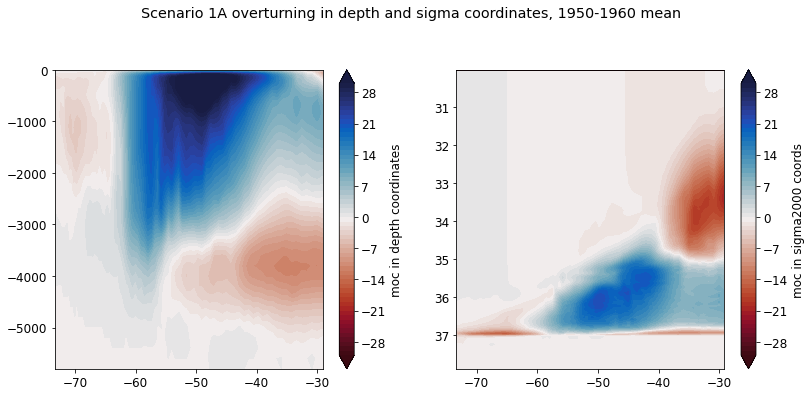

In [126]:

fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

plot_moc(0,s1A_1950_1960_moc_mn)
plot_mocsig(1,s1A_1950_1960_mocsig_mn)


plt.suptitle('Scenario 1A overturning in depth and sigma coordinates, 1950-1960 mean', y = 1.04)

#xr.plot.pcolormesh(s1A_1950_1960_mocsig_mn, ax = axs[1])
# axs[1].set_xticks(tlatind_min60)
# q = axs[1].set_xticklabels(tLatpl)

## depth coordinates, low C scenarion

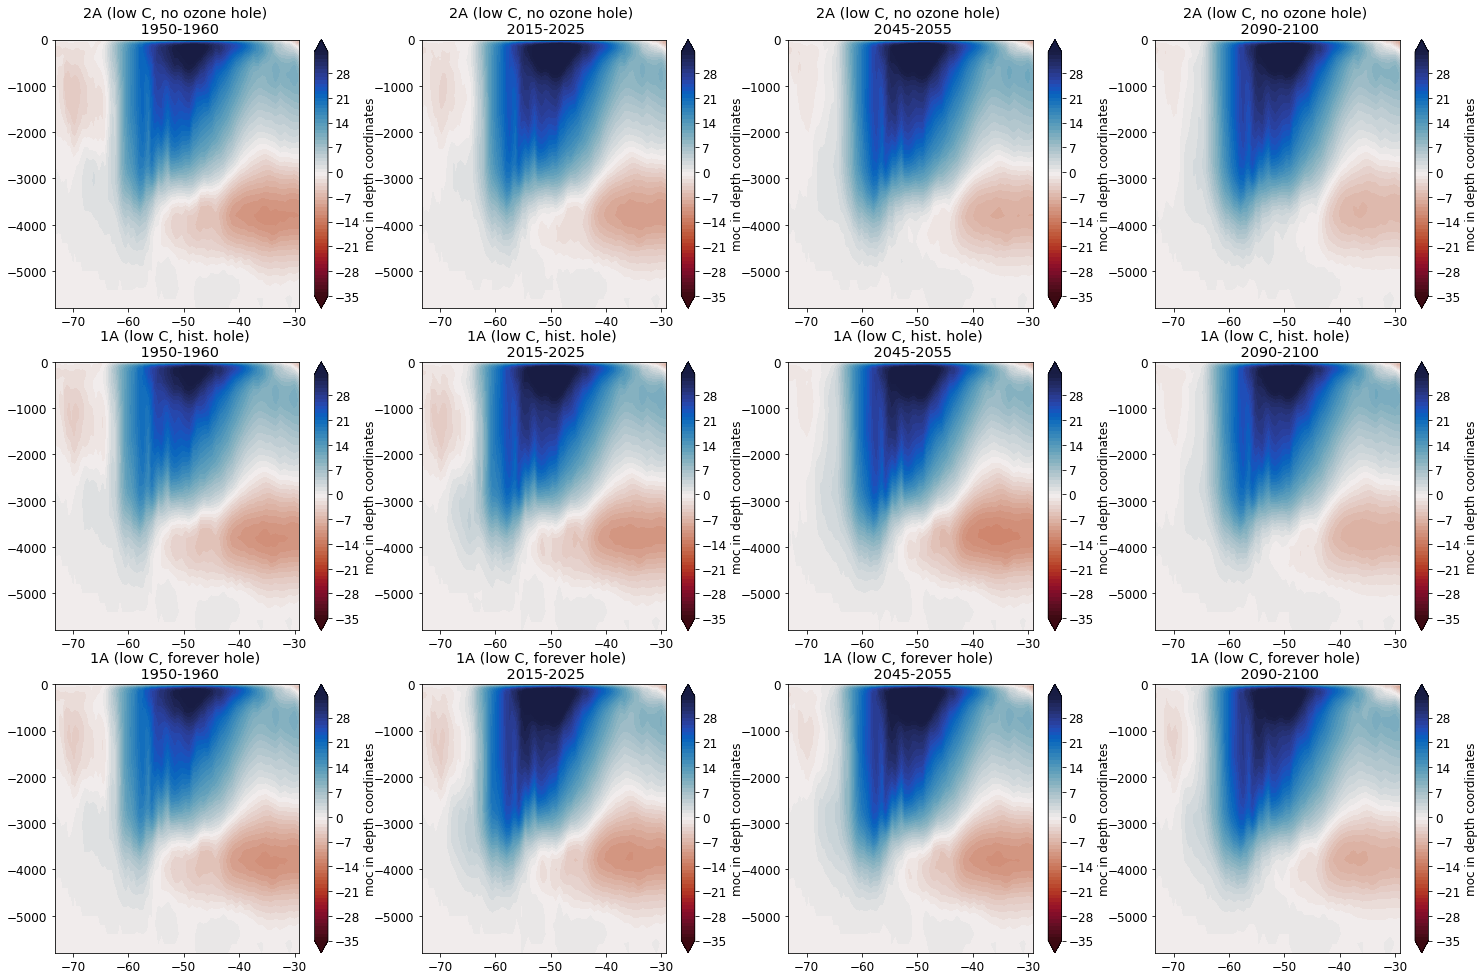

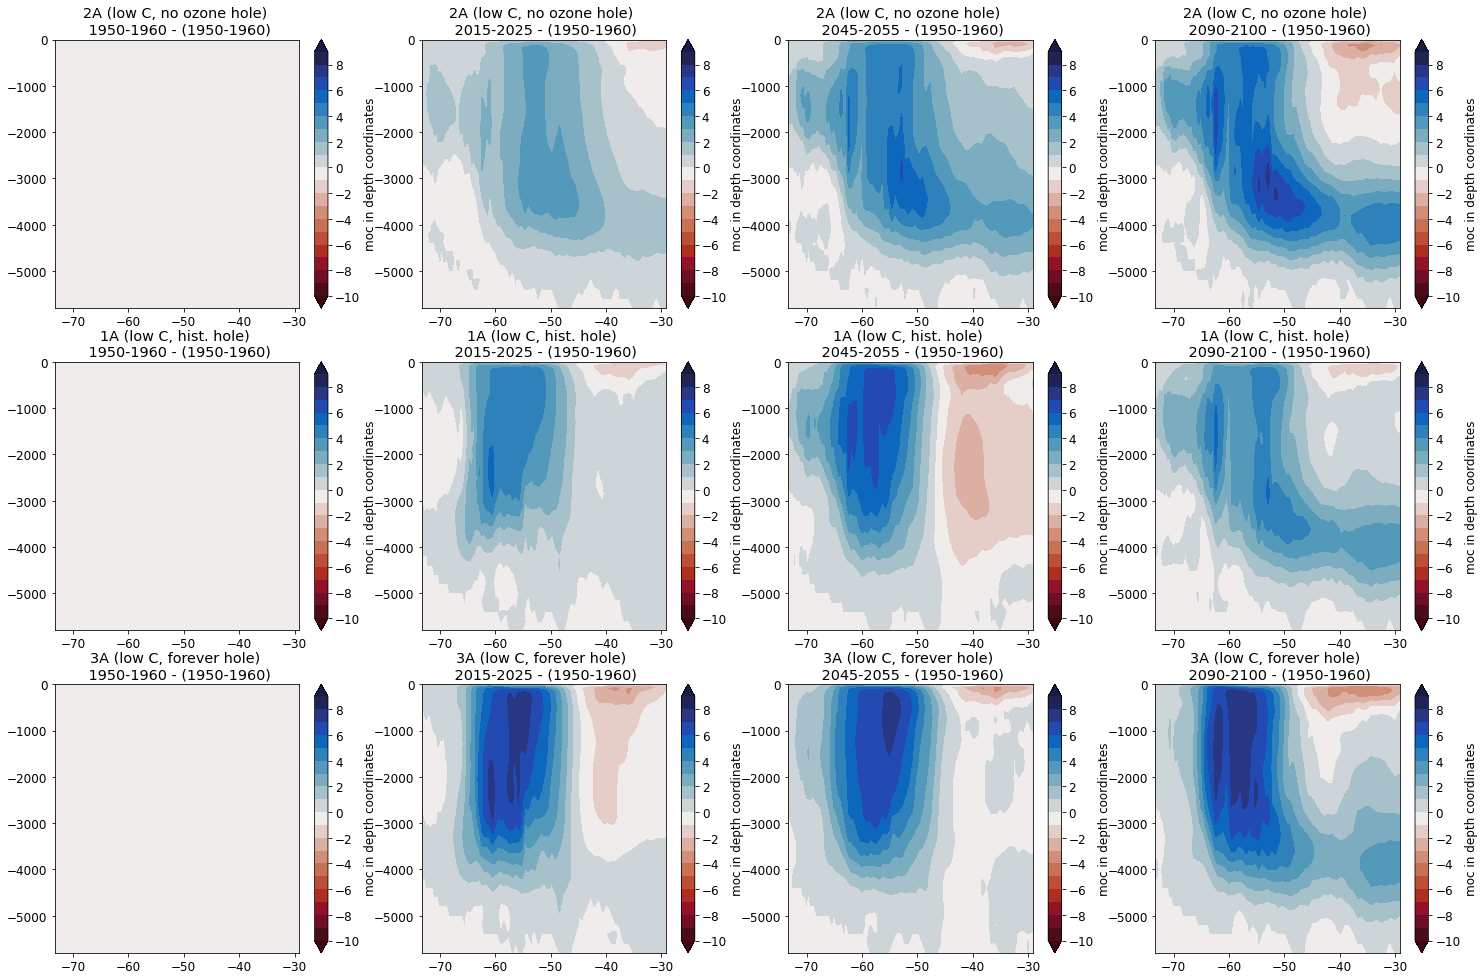

In [127]:

fact = 2.1
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

s1A = [s1A_1950_1960_moc_mn, s1A_2015_2025_moc_mn, s1A_2045_2055_moc_mn, s1A_2090_2100_moc_mn]
s2A = [s2A_1950_1960_moc_mn, s2A_2015_2025_moc_mn, s2A_2045_2055_moc_mn, s2A_2090_2100_moc_mn]
s3A = [s3A_1950_1960_moc_mn, s3A_2015_2025_moc_mn, s3A_2045_2055_moc_mn, s3A_2090_2100_moc_mn]

yrs = ['1950-1960', '2015-2025', '2045-2055', '2090-2100']
tvmin = -35; tvmax = 35
for i in range(0,4):
    plot_moc(i,s2A[i], vmin = -35, vmax = 35)
    axs[i].set_title(f'2A (low C, no ozone hole) \n {yrs[i]}')
    plot_moc(i+4,s1A[i], vmin = -35, vmax = 35)
    axs[i+4].set_title(f'1A (low C, hist. hole) \n {yrs[i]}')
    plot_moc(i+8,s3A[i], vmin = -35, vmax = 35)
    axs[i+8].set_title(f'1A (low C, forever hole) \n {yrs[i]}')    
    

fact = 2.1
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

s1A = [s1A_1950_1960_moc_mn, s1A_2015_2025_moc_mn, s1A_2045_2055_moc_mn, s1A_2090_2100_moc_mn]
s2A = [s2A_1950_1960_moc_mn, s2A_2015_2025_moc_mn, s2A_2045_2055_moc_mn, s2A_2090_2100_moc_mn]
s3A = [s3A_1950_1960_moc_mn, s3A_2015_2025_moc_mn, s3A_2045_2055_moc_mn, s3A_2090_2100_moc_mn]

yrs = ['1950-1960', '2015-2025', '2045-2055', '2090-2100']
tvmin = -10; tvmax = 10
for i in range(0,4):
    plot_moc(i,s2A[i]-s2A[0], vmin = tvmin, vmax = tvmax)
    axs[i].set_title(f'2A (low C, no ozone hole) \n {yrs[i]} - (1950-1960)')
    plot_moc(i+4,s1A[i]-s1A[0], vmin = tvmin, vmax = tvmax)
    axs[i+4].set_title(f'1A (low C, hist. hole) \n {yrs[i]} - (1950-1960)')
    plot_moc(i+8,s3A[i]-s3A[0], vmin = tvmin, vmax = tvmax)
    axs[i+8].set_title(f'3A (low C, forever hole) \n {yrs[i]} - (1950-1960)')    

## depth coordinates, high C scenarion

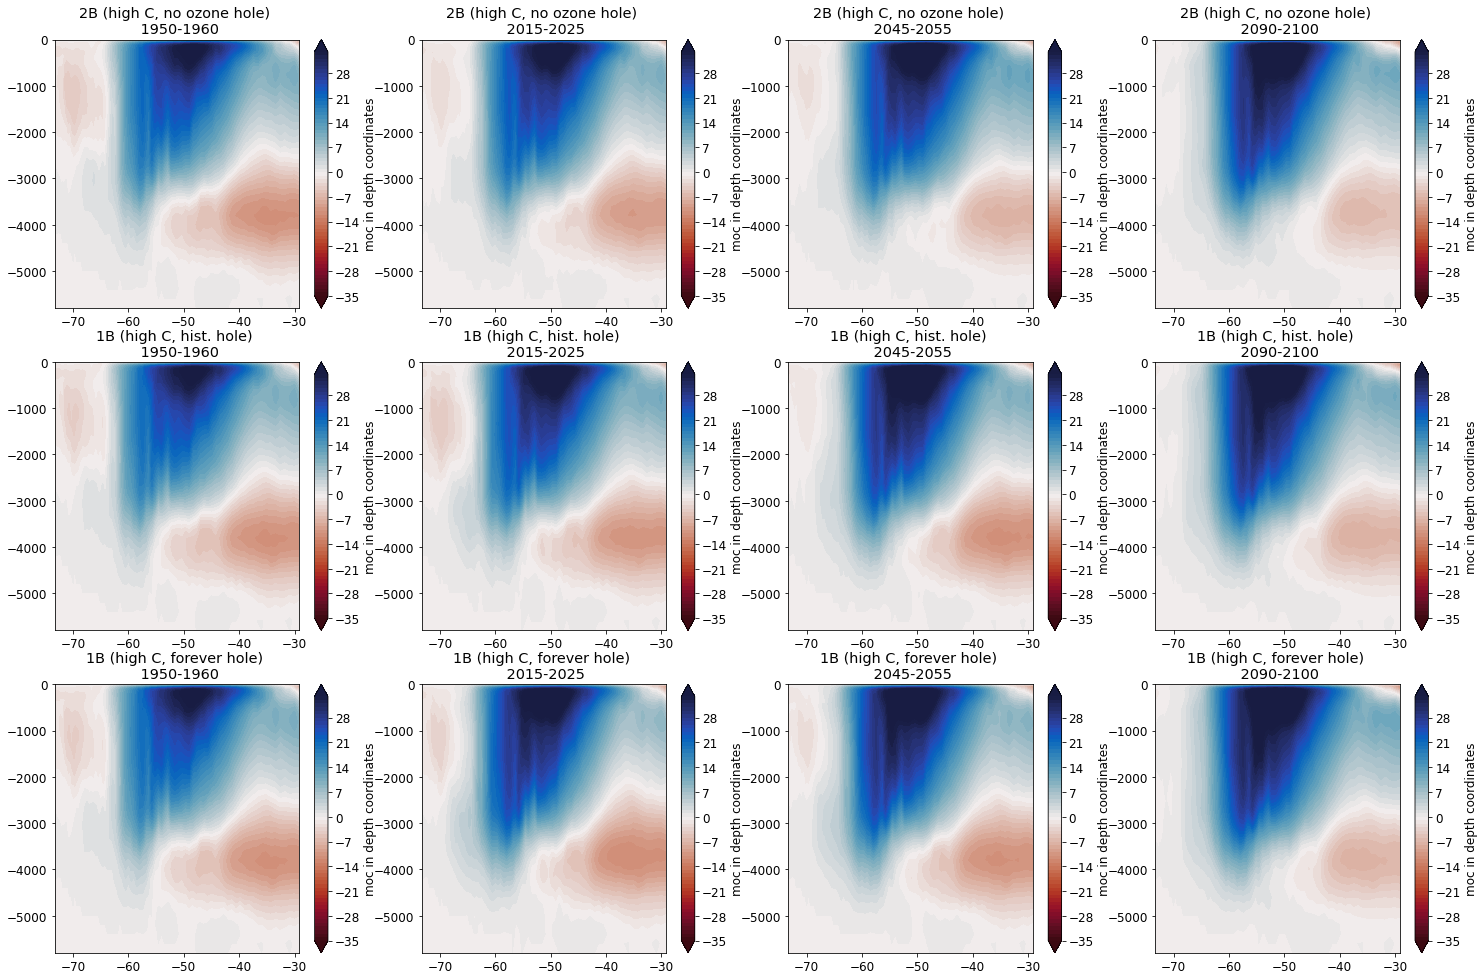

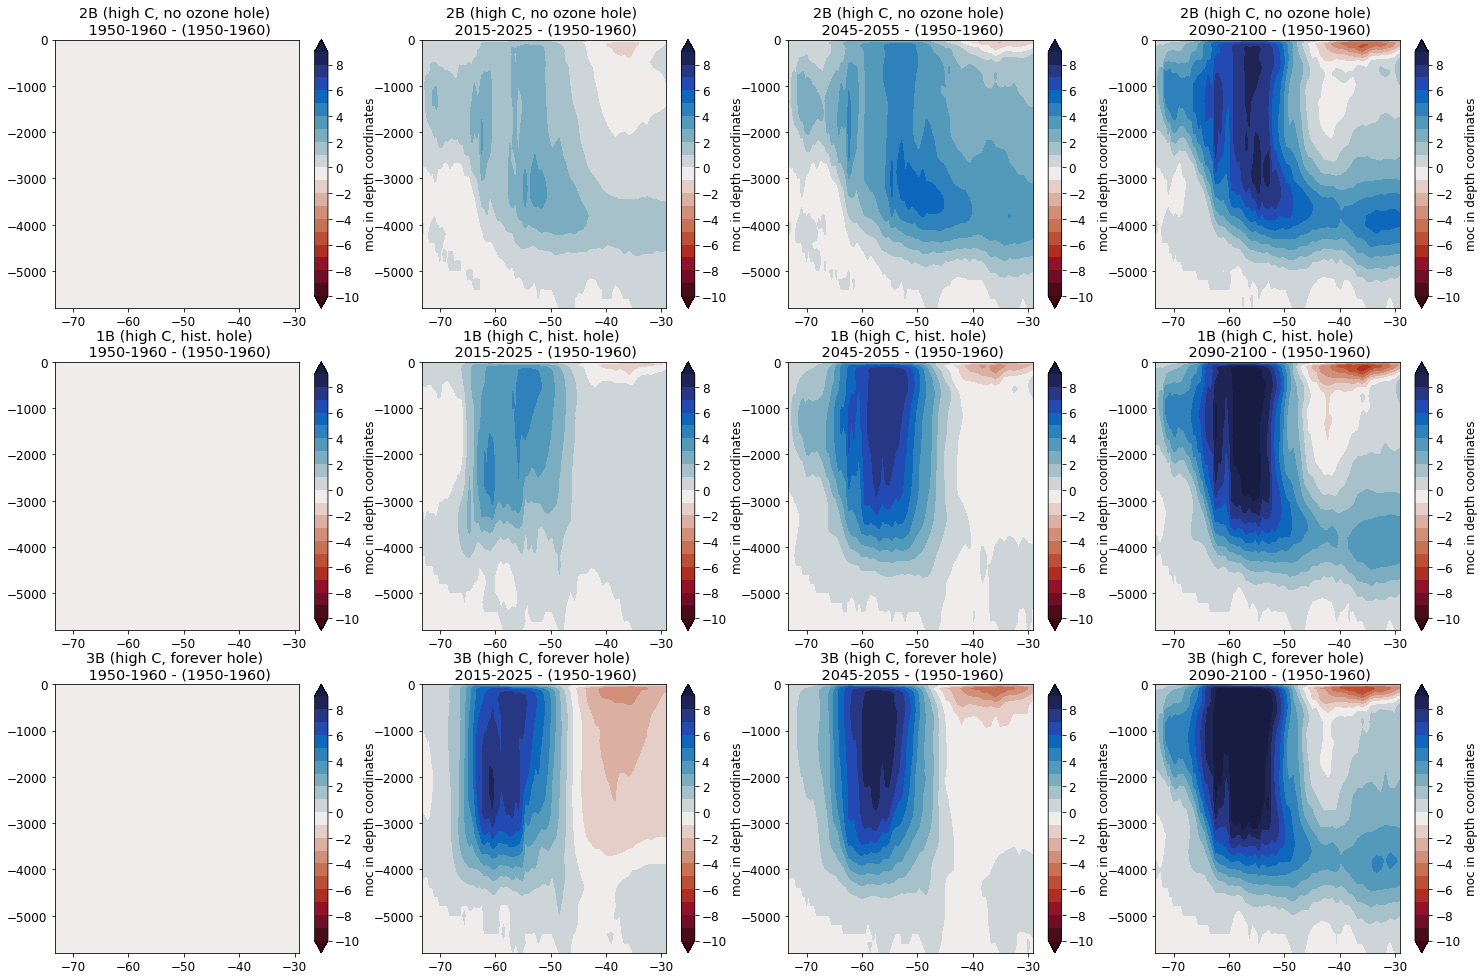

In [128]:

fact = 2.1
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

s1B = [s1B_1950_1960_moc_mn, s1B_2015_2025_moc_mn, s1B_2045_2055_moc_mn, s1B_2090_2100_moc_mn]
s2B = [s2B_1950_1960_moc_mn, s2B_2015_2025_moc_mn, s2B_2045_2055_moc_mn, s2B_2090_2100_moc_mn]
s3B = [s3B_1950_1960_moc_mn, s3B_2015_2025_moc_mn, s3B_2045_2055_moc_mn, s3B_2090_2100_moc_mn]

yrs = ['1950-1960', '2015-2025', '2045-2055', '2090-2100']
tvmin = -35; tvmax = 35
for i in range(0,4):
    plot_moc(i,s2B[i], vmin = -35, vmax = 35)
    axs[i].set_title(f'2B (high C, no ozone hole) \n {yrs[i]}')
    plot_moc(i+4,s1B[i], vmin = -35, vmax = 35)
    axs[i+4].set_title(f'1B (high C, hist. hole) \n {yrs[i]}')
    plot_moc(i+8,s3B[i], vmin = -35, vmax = 35)
    axs[i+8].set_title(f'1B (high C, forever hole) \n {yrs[i]}')    
    

fact = 2.1
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

s1B = [s1B_1950_1960_moc_mn, s1B_2015_2025_moc_mn, s1B_2045_2055_moc_mn, s1B_2090_2100_moc_mn]
s2B = [s2B_1950_1960_moc_mn, s2B_2015_2025_moc_mn, s2B_2045_2055_moc_mn, s2B_2090_2100_moc_mn]
s3B = [s3B_1950_1960_moc_mn, s3B_2015_2025_moc_mn, s3B_2045_2055_moc_mn, s3B_2090_2100_moc_mn]

yrs = ['1950-1960', '2015-2025', '2045-2055', '2090-2100']
tvmin = -10; tvmax = 10
for i in range(0,4):
    plot_moc(i,s2B[i]-s2B[0], vmin = tvmin, vmax = tvmax)
    axs[i].set_title(f'2B (high C, no ozone hole) \n {yrs[i]} - (1950-1960)')
    plot_moc(i+4,s1B[i]-s1B[0], vmin = tvmin, vmax = tvmax)
    axs[i+4].set_title(f'1B (high C, hist. hole) \n {yrs[i]} - (1950-1960)')
    plot_moc(i+8,s3B[i]-s3B[0], vmin = tvmin, vmax = tvmax)
    axs[i+8].set_title(f'3B (high C, forever hole) \n {yrs[i]} - (1950-1960)')    

## sigma

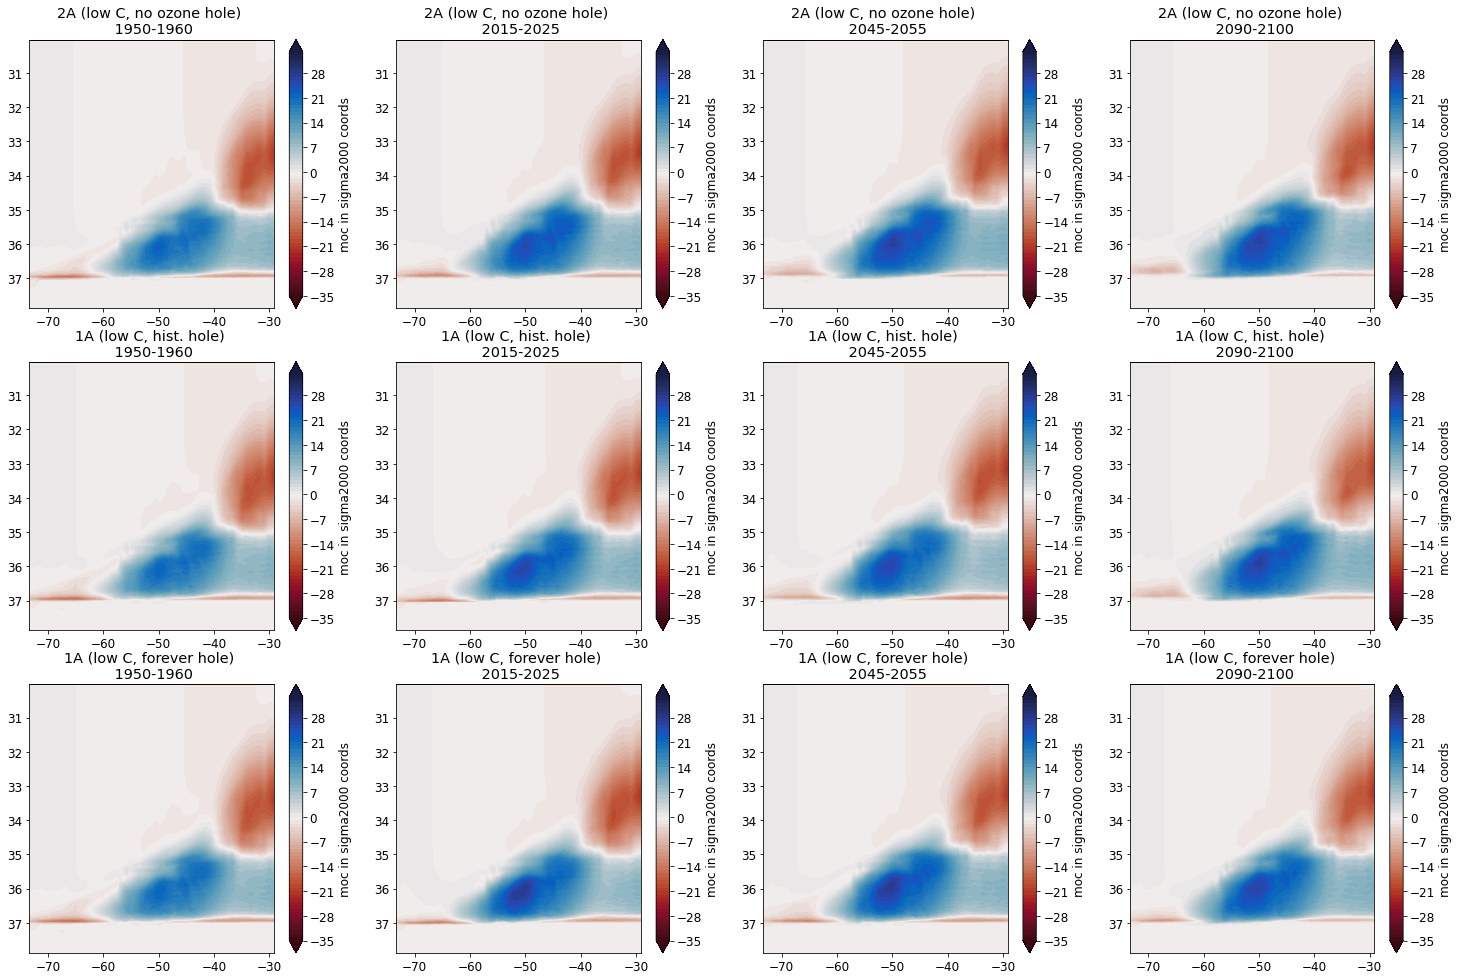

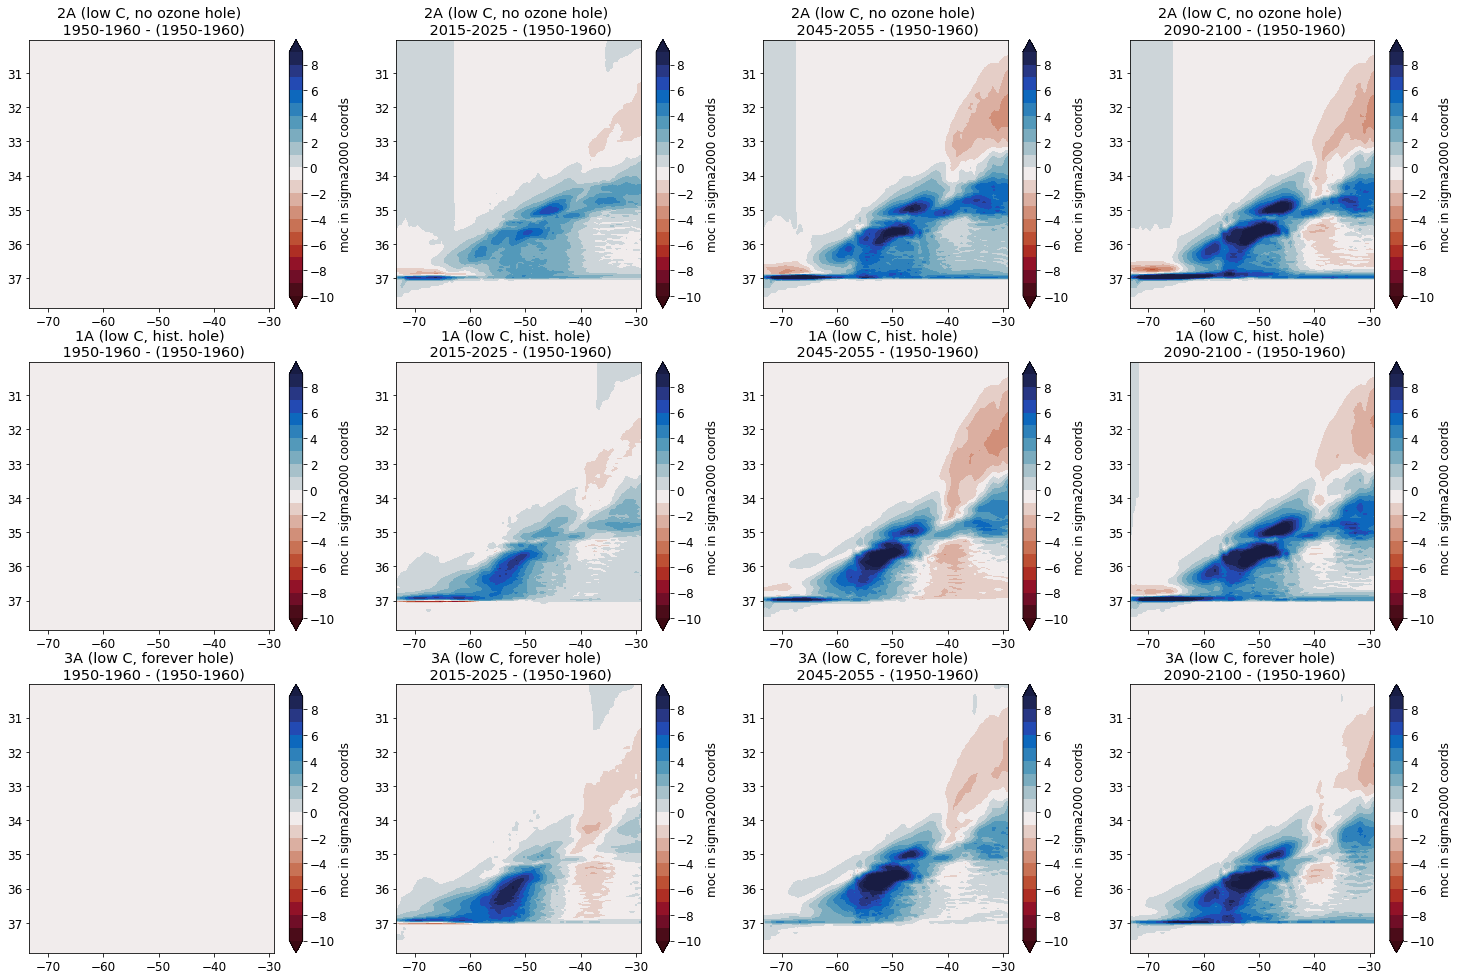

In [129]:
fact = 2.1
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

s1A = [s1A_1950_1960_mocsig_mn, s1A_2015_2025_mocsig_mn, s1A_2045_2055_mocsig_mn, s1A_2090_2100_mocsig_mn]
s2A = [s2A_1950_1960_mocsig_mn, s2A_2015_2025_mocsig_mn, s2A_2045_2055_mocsig_mn, s2A_2090_2100_mocsig_mn]
s3A = [s3A_1950_1960_mocsig_mn, s3A_2015_2025_mocsig_mn, s3A_2045_2055_mocsig_mn, s3A_2090_2100_mocsig_mn]

yrs = ['1950-1960', '2015-2025', '2045-2055', '2090-2100']
tvmin = -35; tvmax = 35
for i in range(0,4):
    plot_mocsig(i,s2A[i], vmin = -35, vmax = 35)
    axs[i].set_title(f'2A (low C, no ozone hole) \n {yrs[i]}')
    plot_mocsig(i+4,s1A[i], vmin = -35, vmax = 35)
    axs[i+4].set_title(f'1A (low C, hist. hole) \n {yrs[i]}')
    plot_mocsig(i+8,s3A[i], vmin = -35, vmax = 35)
    axs[i+8].set_title(f'1A (low C, forever hole) \n {yrs[i]}')    
    

fact = 2.1
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

s1A = [s1A_1950_1960_mocsig_mn, s1A_2015_2025_mocsig_mn, s1A_2045_2055_mocsig_mn, s1A_2090_2100_mocsig_mn]
s2A = [s2A_1950_1960_mocsig_mn, s2A_2015_2025_mocsig_mn, s2A_2045_2055_mocsig_mn, s2A_2090_2100_mocsig_mn]
s3A = [s3A_1950_1960_mocsig_mn, s3A_2015_2025_mocsig_mn, s3A_2045_2055_mocsig_mn, s3A_2090_2100_mocsig_mn]

yrs = ['1950-1960', '2015-2025', '2045-2055', '2090-2100']
tvmin = -10; tvmax = 10
for i in range(0,4):
    plot_mocsig(i,s2A[i]-s2A[0], vmin = tvmin, vmax = tvmax)
    axs[i].set_title(f'2A (low C, no ozone hole) \n {yrs[i]} - (1950-1960)')
    plot_mocsig(i+4,s1A[i]-s1A[0], vmin = tvmin, vmax = tvmax)
    axs[i+4].set_title(f'1A (low C, hist. hole) \n {yrs[i]} - (1950-1960)')
    plot_mocsig(i+8,s3A[i]-s3A[0], vmin = tvmin, vmax = tvmax)
    axs[i+8].set_title(f'3A (low C, forever hole) \n {yrs[i]} - (1950-1960)')    

## sigma, high C

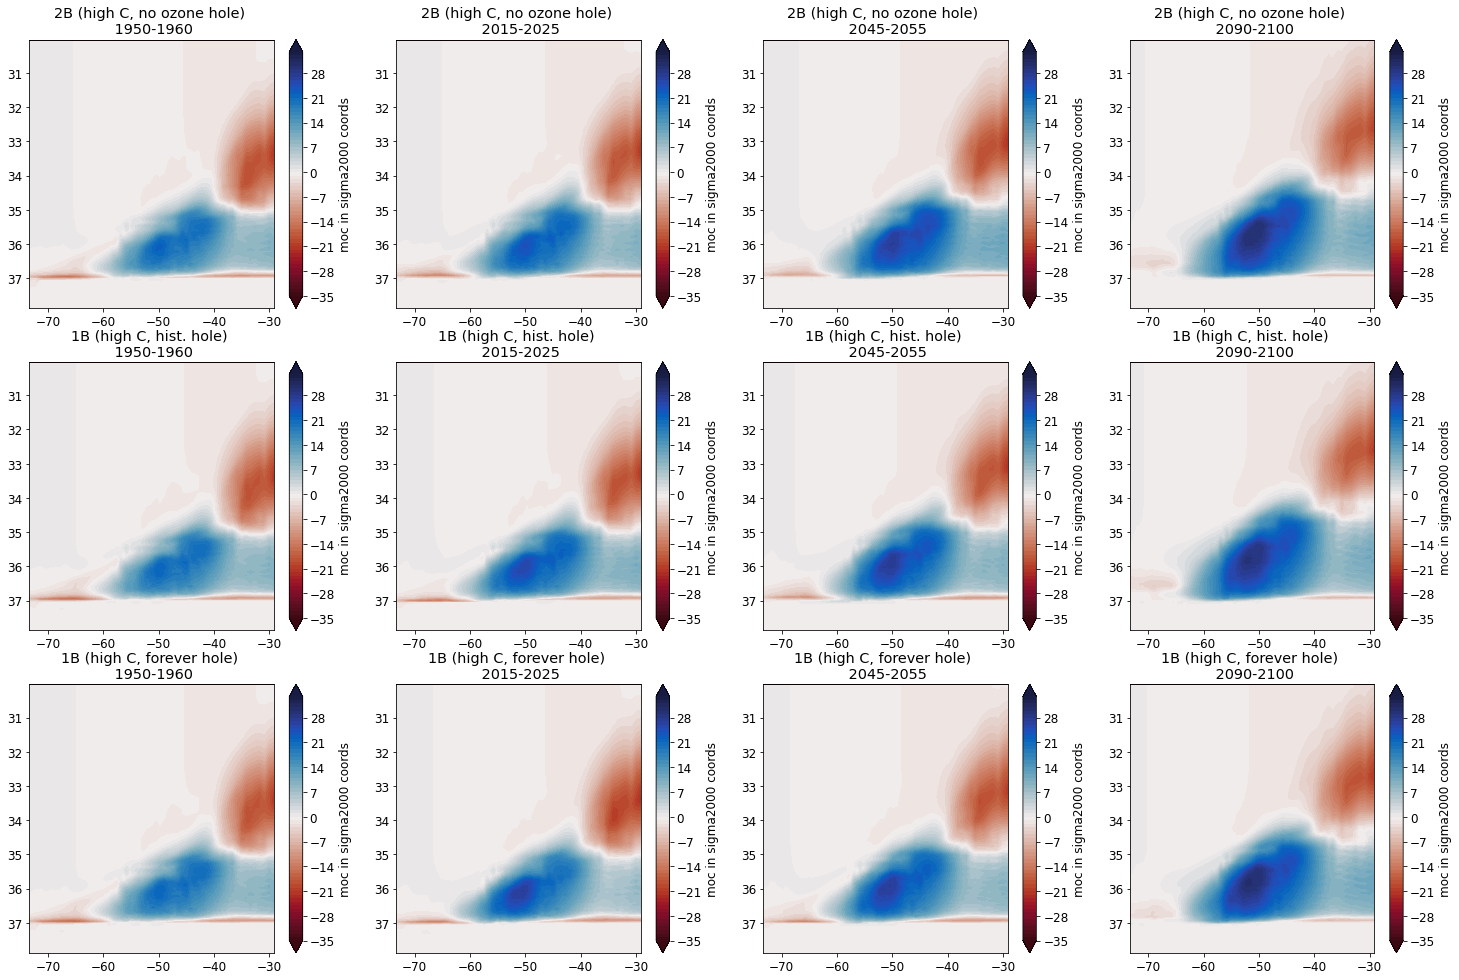

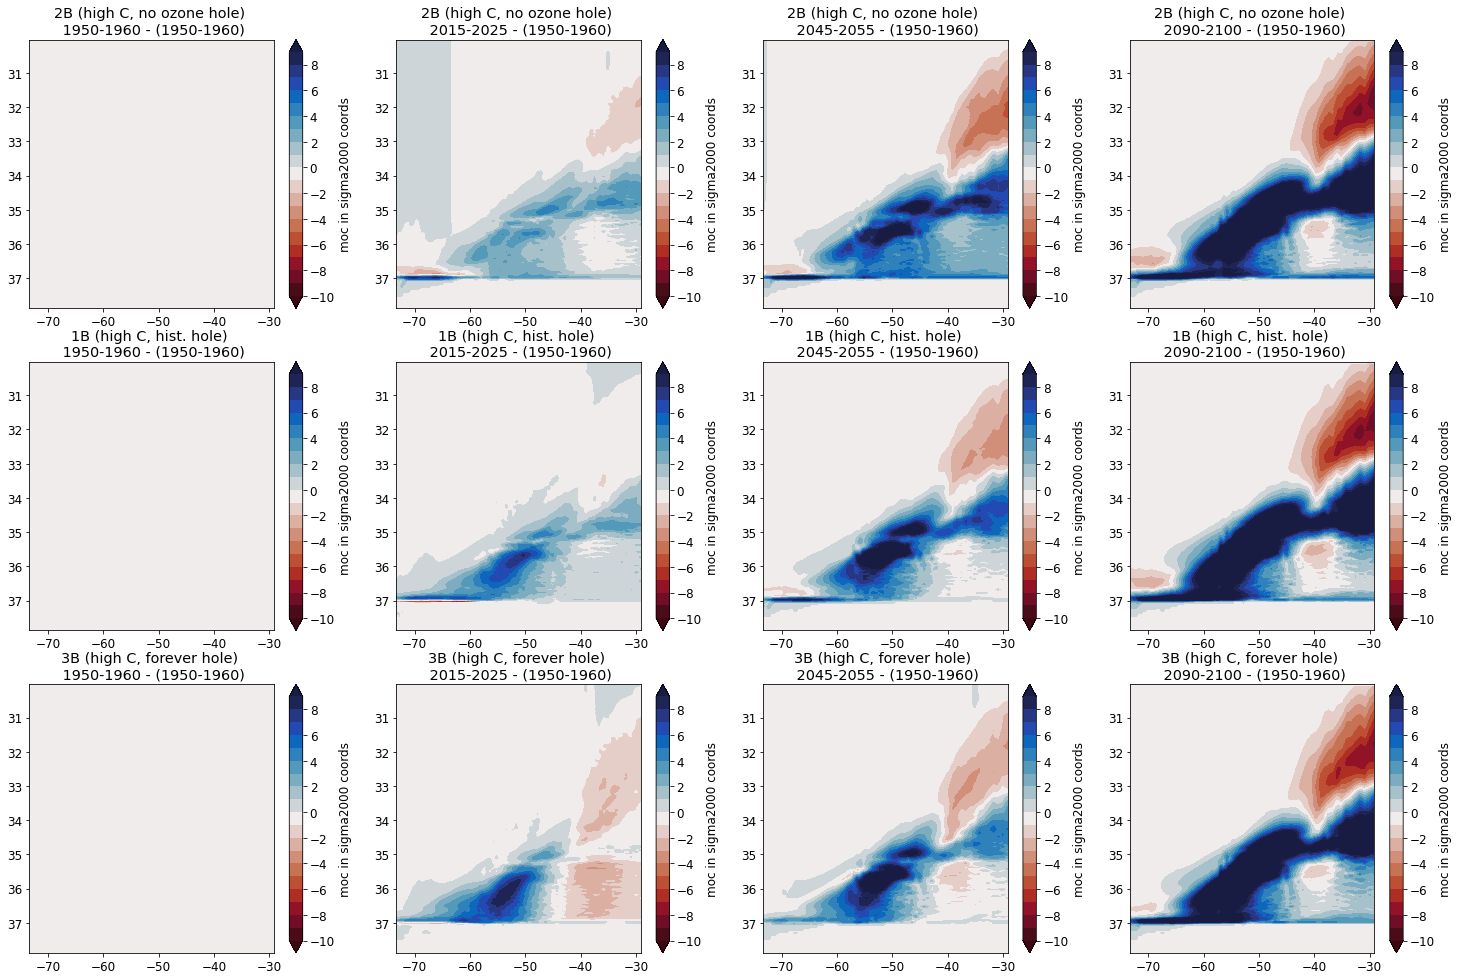

In [130]:

fact = 2.1
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

s1B = [s1B_1950_1960_mocsig_mn, s1B_2015_2025_mocsig_mn, s1B_2045_2055_mocsig_mn, s1B_2090_2100_mocsig_mn]
s2B = [s2B_1950_1960_mocsig_mn, s2B_2015_2025_mocsig_mn, s2B_2045_2055_mocsig_mn, s2B_2090_2100_mocsig_mn]
s3B = [s3B_1950_1960_mocsig_mn, s3B_2015_2025_mocsig_mn, s3B_2045_2055_mocsig_mn, s3B_2090_2100_mocsig_mn]

yrs = ['1950-1960', '2015-2025', '2045-2055', '2090-2100']
tvmin = -35; tvmax = 35
for i in range(0,4):
    plot_mocsig(i,s2B[i], vmin = -35, vmax = 35)
    axs[i].set_title(f'2B (high C, no ozone hole) \n {yrs[i]}')
    plot_mocsig(i+4,s1B[i], vmin = -35, vmax = 35)
    axs[i+4].set_title(f'1B (high C, hist. hole) \n {yrs[i]}')
    plot_mocsig(i+8,s3B[i], vmin = -35, vmax = 35)
    axs[i+8].set_title(f'1B (high C, forever hole) \n {yrs[i]}')    
    

fact = 2.1
fig, axs = plt.subplots(3,4, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

s1B = [s1B_1950_1960_mocsig_mn, s1B_2015_2025_mocsig_mn, s1B_2045_2055_mocsig_mn, s1B_2090_2100_mocsig_mn]
s2B = [s2B_1950_1960_mocsig_mn, s2B_2015_2025_mocsig_mn, s2B_2045_2055_mocsig_mn, s2B_2090_2100_mocsig_mn]
s3B = [s3B_1950_1960_mocsig_mn, s3B_2015_2025_mocsig_mn, s3B_2045_2055_mocsig_mn, s3B_2090_2100_mocsig_mn]

yrs = ['1950-1960', '2015-2025', '2045-2055', '2090-2100']
tvmin = -10; tvmax = 10
for i in range(0,4):
    plot_mocsig(i,s2B[i]-s2B[0], vmin = tvmin, vmax = tvmax)
    axs[i].set_title(f'2B (high C, no ozone hole) \n {yrs[i]} - (1950-1960)')
    plot_mocsig(i+4,s1B[i]-s1B[0], vmin = tvmin, vmax = tvmax)
    axs[i+4].set_title(f'1B (high C, hist. hole) \n {yrs[i]} - (1950-1960)')
    plot_mocsig(i+8,s3B[i]-s3B[0], vmin = tvmin, vmax = tvmax)
    axs[i+8].set_title(f'3B (high C, forever hole) \n {yrs[i]} - (1950-1960)')    

In [131]:
print('lol')

lol
